# Análisis de preguntas similares

## 1. Importación de librerías

In [27]:
# Generales
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import seaborn as sns

# Sklearn
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer  # Stopwords
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


# Tensorflow y Keras
from keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, Embedding, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, losses
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 2. Carga del csv y configuración de parámetros principales

In [28]:
# Parámetros configurables
N = 60  # Número de palabras del diccionario
T = 60    # Longitud prefijada de la reseña
D = 60
EPOCHS = 2
NEURONAS = 64

# Usamos la lista de stopwords de sklearn
stop_words = list(ENGLISH_STOP_WORDS)

datos = pd.read_csv("/kaggle/input/preguntas/preguntas.csv")

In [29]:
datos.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [30]:
datos['question1'].apply(len).mean()

59.494476666666664

In [31]:
datos.drop(["id", "qid1", "qid2"], axis=1, inplace=True)

In [32]:
datos.head()

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [33]:
def get_dictionary(text, sw, N):
    vectorizer = CountVectorizer(stop_words=sw, max_features=N)
    vectorizer.fit_transform(text)
    dictionary = vectorizer.vocabulary_
    dictionary = {word: i + 2 for i, word in enumerate(vectorizer.get_feature_names_out())}
    dictionary['DESC'] = 0
    dictionary['PAD'] = 1
    return dictionary

In [34]:
def text_to_sequence(text, dictionary, stop_words, T):
    palabras = re.findall(r'[^a-z\s]', text.lower()) #Tokenizar
    palabras = [palabra for palabra in palabras if palabra not in stop_words]
    secuencia = [dictionary.get(palabra, dictionary['DESC']) for palabra in palabras]
    secuencia = secuencia[:T]
    secuencia += [dictionary['PAD']] * (T - len(secuencia))
    return np.array(secuencia)

In [35]:
# Variable objetivo
y = datos.iloc[:, -1]
num_clases = len(y.unique())
# Codificamos con "one hot" las posibles categorías finales
# y = pd.get_dummies(datos['is_duplicate'], columns=['is_duplicate'])

datos["preguntas"] = datos["question1"] + datos["question2"]

# Textos de reseñas
textos = datos['preguntas']
X = []
diccionario = get_dictionary(textos, stop_words, N)
for texto in textos:
    X.append(text_to_sequence(texto, diccionario, stop_words, T))
# X contendrá las reseñas codificadas y rellenas con la misma longitud
X = np.array(X)

In [36]:
textos = datos['preguntas']
X = pad_sequences(textos.apply(lambda t: text_to_sequence(t, diccionario, stop_words, T)), maxlen=T, padding='post')  # T debe ser la longitud deseada (ej: 100)
y = pd.get_dummies(datos['is_duplicate'])

In [37]:
#def train_test_split_rnn(X, y, train_size=0.8):
    
 #   n_train = int(len(X) * train_size)  # Número de muestras para entrenamiento

  #  X_train, X_test = X[:n_train], X[n_train:]
   # y_train, y_test = y[:n_train], y[n_train:]

    #return X_train, X_test, y_train, y_test

In [38]:
#X_train, X_test, y_train, y_test = train_test_split_rnn(X, y, train_size=0.8)

In [39]:
model = Sequential([
    Input(shape=(T,)),  # Solo longitud de secuencia (100)
    Embedding(input_dim=N+2, output_dim=D),
    Bidirectional(LSTM(units=NEURONAS, return_sequences=True)),
    Bidirectional(LSTM(units=NEURONAS)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_clases, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 60, 60)              │           3,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 60, 128)             │          64,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 191,434 (747.79 KB)

 Trainable params: 191,434 (747.79 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
history = model.fit(X, y, validation_split=0.2, epochs=EPOCHS, batch_size=64, verbose=1)

Epoch 1/2
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 81s 21ms/step - accuracy: 0.6274 - loss: 0.6439 - val_accuracy: 0.6304 - val_loss: 0.6392
Epoch 2/2
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 77s 21ms/step - accuracy: 0.6291 - loss: 0.6401 - val_accuracy: 0.6304 - val_loss: 0.6390


In [41]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

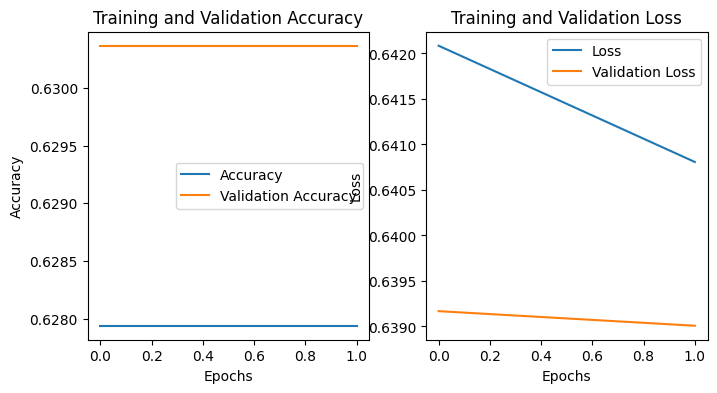

In [42]:
# Plotting the accuracy and loss over time

# Training history
history_dict = history.history

# Seperating validation and training accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Seperating validation and training loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plotting
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'])

plt.show()

In [43]:
def train_validation(model, X_test, y_test):
   
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convertir probabilidades en etiquetas binarias

    # Matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Reporte de clasificación
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred, target_names=["No Duplicado", "Duplicado"]))

    # Mostrar matriz de confusión con heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=["No Duplicado", "Duplicado"],
                yticklabels=["No Duplicado", "Duplicado"])
    plt.title("Matriz de Confusión")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

# Llama a la función con el modelo ya entrenado
#train_validation(model, X_test, y_test)